<a href="https://colab.research.google.com/github/dangcaptkd/CS114.K21-/blob/master/CaseStudy01-sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sarcasm detection**

**Nhóm**
1.   Nguyễn Thịnh Quyền - 18521322
2.   Lê Đoàn Nhật Minh - 18521011
3.   Võ Huy Khôi - 18520949

**Bài toán**

Dự đoán 1 headline có phải là tin chấm biếm hay không?

Bài toàn thuộc dạng Binary-Classification

**Data train**
  *   Data train được lấy từ kaggle: News Headlines Dataset For Sarcasm Detection
  *   Dataset-train gồm:
    *   is_sarcastic: là 1 nếu là sarcasm ngược lại là 0
    *   headline: tiêu đề
    *   article_link: link của article
  *   Chia data train test theo tỉ lệ 9/1 (2670 headline để test, 24039 headline để train)


**Các kĩ thuật xử lý data**

  * Regular Expression: loại bỏ các kí tự không cần thiết. Ex: don't ---> don t
  * Stemming data: đưa các từ về hình thức gốc của nó. Ex: loved---> love
  * TF-IDF (Term frequency-Inverse document frequency): 
    * TF: là số lần xuất hiện của từ đó trong văn bản
    * IDF: Tần số nghịch của 1 từ trong tập văn bản 
    * tfidf = TF*IDF, những từ có tần số ifidf cao là những từ xuất hiện nhiều trong văn bản này, và xuất hiện ít trong các văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khoá của văn bản đó).

**Sử dụng model**

1.   LinearSVC
2.   GausinanNB
3.   LogisticRegression
4.   DecisionTreeClassifier
5.   RandomForestClassifier



**Data test**


*   Sử dụng thư viện BeautifulSoup để crawl data từ 2 trang web: the Onion và CNN
*   1500 headlines cho mỗi label












Lấy data từ kaggle!



In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quyennguyenthinh","key":"52c200c7cee98c6a1dd7c6433c61afd8"}'}

In [2]:
#!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 112MB/s]


In [4]:
!unzip news-headlines-dataset-for-sarcasm-detection

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


# Load,show, check, pre-processing, training and testing data
#(regular expression, steming, TF-IDF Vectorizer)

In [5]:
import pandas as pd
import numpy as np
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

load data from jason file

In [6]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)

show data

In [7]:
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


Check the null value

In [8]:
print(data.isnull().any(axis = 0))

article_link    False
headline        False
is_sarcastic    False
dtype: bool


**So sánh số lượng headline sarcasm và non-sarcasm**

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

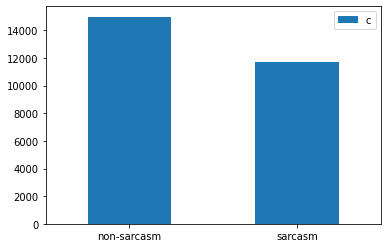

In [51]:
import matplotlib.pyplot as plt

names = ['non-sarcasm', 'sarcasm']
temp = data['is_sarcastic'].value_counts()
d = pd.DataFrame({
    "c" : [temp[0], temp[1]]},
    index = names)
d.plot(kind='bar')
plt.xticks(rotation =0, horizontalalignment = "center")

**pre-processing data**

Ở cột headline sẽ có 1 vài kí tự cần được loại bỏ('?.+-="/...), dùng regular expression để loại bỏ các kí tự này

In [ ]:
print('Example')
print('before:',data['headline'][0])
data['headline'] = data['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))
print('after: {}'.format(data['headline'][0]))

Example
before: former versace store clerk sues over secret 'black code' for minority shoppers
after: former versace store clerk sues over secret  black code  for minority shoppers


Gán feature và label 

In [ ]:
features = data['headline']
labels = data['is_sarcastic']

**Stemming**

Stemming là 1 kĩ thuật đưa các từ về hình thức gốc của nó, ex: loved-->love

In [ ]:
print('Example')
print('before stemstming:', features[0])
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))
print('after stemming:', features[0])

Example
before stemstming: former versace store clerk sues over secret  black code  for minority shoppers
after stemming: former versac store clerk sue over secret black code for minor shopper


**TF-IDF Vectorizer**

*   TfidfVectorizer(): "Convert a collection of raw documents to a matrix of TF-IDF features."
*   TfidfVectorizer.fit_transform(): "Learn vocabulary and idf, return **document-term matrix**"

Document-term matrix là ma trận có các hàng tương ứng với văn bản, các cột tương ứng với từng từ

Ex:
 
![alt text](https://www.researchgate.net/profile/Khawar_Mehmood/publication/342027900/figure/tbl2/AS:900374928031745@1591677519266/Example-of-document-term-matrix-Unigram.png)






In [ ]:
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

Import thư viện cần thiết

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

split và show shape data

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.1, random_state = 0)

**training and testing data**

Sử dụng các model để train: LinearSVC, GausinanNB, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

In [ ]:
models = []
models.append(('LinearSVC', LinearSVC()))
models.append(('GaussianNB', GaussianNB()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

In [ ]:
for name, model in models:
  model.fit(features_train, labels_train)
  print(name)
  print('\tscore train:', model.score(features_train, labels_train))
  print('\tscore test:', model.score(features_test, labels_test))

LinearSVC
	score train: 0.9110574923038522
	score test: 0.8360164732309996
GaussianNB
	score train: 0.7826358266078709
	score test: 0.7162111568700861
LogisticRegression
	score train: 0.8824777435726766
	score test: 0.8375140396855111
DecisionTreeClassifier
	score train: 0.999875197603794
	score test: 0.7540247098464994
RandomForestClassifier
	score train: 0.999875197603794
	score test: 0.8199176338450018


**Nhận xét**

So với các kernel trong kaggle thì kết quả này cho ra khá tương đồng nên em nghỉ số điểm này là số điểm chấp nhận được.

Em nghĩ có thể cải thiện score bằng deeplearning 

# Crawl data

*   **output là 1 dataframe tên là df có 3000 headline gồm 1500 sarcasm và 1500 non-sarcasm**



In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np

**The onion**

In [ ]:
url = "https://www.theonion.com/latest"
more_stories = ''
data_sarcasm = []
while len(data_sarcasm)<2000:
  r1 = requests.get(url+more_stories)
  coverpage = r1.content
  soup1 = BeautifulSoup(coverpage, 'html5lib')
  coverpage_news = soup1.find_all("h2", class_="sc-759qgu-0 cYlVdn cw4lnv-6 eXwNRE")
  for i in coverpage_news:
    data_sarcasm.append(i.get_text())
  
  t = soup1.find_all("a", class_="sc-1out364-0 hMndXN js_link")
  more_stories = t[-1].get('href')

In [ ]:
data_sarcasm = list(set(data_sarcasm))
len(data_sarcasm)

1999

In [ ]:
is_sarcasm_sarcasm = [1]*len(data_sarcasm)

**CNN**

In [ ]:
def get_href(url, title):
  r1 = requests.get(url)
  coverpage = r1.content
  soup1 = BeautifulSoup(coverpage, 'html5lib')

  coverpage_news = soup1.find_all("a", class_="cn__title--link icon")
  for i in coverpage_news:
    t = i.get('href')
    if t[0]!='/':
      if "https://edition.cnn.com" in t or 'http://edition.cnn.com' in t:
        title.add(t)
    else:
      title.add("https://edition.cnn.com"+t)
    

In [ ]:
url = "https://edition.cnn.com/world"
## title 
title = set()
get_href(url, title)

# title1
title1 = set()
for url in title:
  get_href(url, title1)

# title2
title2 = set()
for url in title1:
  get_href(url, title2)

#title3
title3 = set()
for url in title2:
  get_href(url, title3)

title4 = set()
for url in title3:
  get_href(url, title4)

#option_title
option_title = set([
                    'https://edition.cnn.com/politics',
                    'https://edition.cnn.com/business',
                    'https://edition.cnn.com/health',
                    'https://edition.cnn.com/entertainment',
                    'https://edition.cnn.com/style',
                    'https://edition.cnn.com/travel',
                    'https://edition.cnn.com/sport'
])

In [ ]:
print(len(title))
print(len(title1))
print(len(title2))
print(len(title3))

13
31
42
43


In [ ]:
biggest_title = title|title1|title2|title3|title4|option_title
biggest_title

{'http://edition.cnn.com/specials/africa/african-voices',
 'http://edition.cnn.com/specials/africa/inside-africa',
 'http://edition.cnn.com/specials/business/marketplace-africa',
 'http://edition.cnn.com/specials/health/live-longer',
 'http://edition.cnn.com/specials/world/the-modern-explorers',
 'http://edition.cnn.com/sport',
 'http://edition.cnn.com/sport/equestrian',
 'http://edition.cnn.com/sport/golf',
 'http://edition.cnn.com/travel',
 'http://edition.cnn.com/travel/destinations/kenya',
 'https://edition.cnn.com/190406071249-03-rwandan-daughters-cnnphotos-restricte.jpg',
 'https://edition.cnn.com/Africa',
 'https://edition.cnn.com/americas',
 'https://edition.cnn.com/asia',
 'https://edition.cnn.com/brexit',
 'https://edition.cnn.com/business',
 'https://edition.cnn.com/business/india',
 'https://edition.cnn.com/entertainment',
 'https://edition.cnn.com/europe',
 'https://edition.cnn.com/health',
 'https://edition.cnn.com/middle-east',
 'https://edition.cnn.com/politics',
 'http

In [ ]:
len(biggest_title)

45

In [ ]:
data_non_sarcasm = []
for url in biggest_title:

  r1 = requests.get(url)
  coverpage = r1.content
  soup1 = BeautifulSoup(coverpage, 'html5lib')
  
  coverpage_news = soup1.find_all("span", class_="cd__headline-text")
  for i in coverpage_news:
    data_non_sarcasm.append(i.get_text())

In [ ]:
data_non_sarcasm = list(set(data_non_sarcasm))
print(len(data_non_sarcasm))

1516


In [ ]:
is_sarcasm_non_sarcasm = [0]*len(data_non_sarcasm)

**Hoàn thành dataset test**

In [ ]:
headline = data_sarcasm[:1500] + data_non_sarcasm[:1500] 
is_sarcasm = is_sarcasm_sarcasm[:1500] + is_sarcasm_non_sarcasm[:1500]
print(len(headline))
print(len(is_sarcasm))

3000
3000


In [ ]:
data_test = pd.DataFrame({
    'headline': headline,
    'is_sarcasm': is_sarcasm
})

In [ ]:
from sklearn.utils import shuffle
df = shuffle(data_test).reset_index(drop=True)
df

,headline,is_sarcasm
0,Jennifer Gates juggles her love of horses with...,0
1,How female scientists are losing out during th...,0
2,All The Substitute Teachers We Absolutely Wrec...,1
3,"God Stumbles On Old, Beat-Up Planet That He Ca...",1
4,The Onion’s Guide To The 2020 Oscars: Best Dir...,1
...,...,...
2995,Mom Changes Words Of Prayer To Be More Cheerful,1
2996,The ideal gift for Her - Topshop,0
2997,Computer Not Looking Forward To Having To Repl...,1
2998,Premier League players take a knee -- and make...,0


# Test 

**Xử lý data như tập train**

In [ ]:
df['headline'] = df['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [ ]:
x_valid = df['headline']
y_valid = df['is_sarcasm']

In [ ]:
ps = PorterStemmer()
x_valid = x_valid.apply(lambda x: x.split())
x_valid = x_valid.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [ ]:
x_valid = list(x_valid)
x_valid = tv.transform(x_valid).toarray()
x_valid.shape

(3000, 5000)

**Đưa ra dự đoán**

In [ ]:
from sklearn.metrics import accuracy_score
for name, model in models:
  print(name)
  pred = model.predict(x_valid)
  print('\tscore: {}'.format(accuracy_score(pred, 
                                         y_valid)))

LinearSVC
	score: 0.6953333333333334
GaussianNB
	score: 0.597
LogisticRegression
	score: 0.6886666666666666
DecisionTreeClassifier
	score: 0.6156666666666667
RandomForestClassifier
	score: 0.6676666666666666


**Nhận xét**

Các điểm accuracy ở test này thấp hơn so với phần valid, có thể là do phạm vi word trong tập train chưa đủ lớn để dự đoàn các headline trên bất kì phạm vi nào. 

Giải pháp: em nghĩ cần tập train lớn hơn và đc lấy về từ nhiều nguồn trang web hơn.

# Test by user

In [ ]:
user = pd.DataFrame({'headline': [input()], 'sarcasm': '?'})

Trump is the "greatest" president


In [ ]:
user

,headline,sarcasm
0,"Trump is the ""greatest"" president",?


**Xử lý data như tập train**

In [ ]:
user['headline'] = user['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [ ]:
s = user['headline']

In [ ]:
ps = PorterStemmer()
s = s.apply(lambda x: x.split())
s = s.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [ ]:
s = list(s)
s = tv.transform(s).toarray()

In [ ]:
for name, model in models:
  print(name)
  print(model.predict(s))

LinearSVC
[0]
GaussianNB
[1]
LogisticRegression
[0]
DecisionTreeClassifier
[0]
RandomForestClassifier
[0]


**Nhận xét**

Qua input đầu vào này, thấy được độ chính xác thật sự là chưa cao, mặc dù model GausianNB có điểm accuracy train, test thấp nhất, nhưng lại dự đoàn đúng :>



**Thanks For Reading**